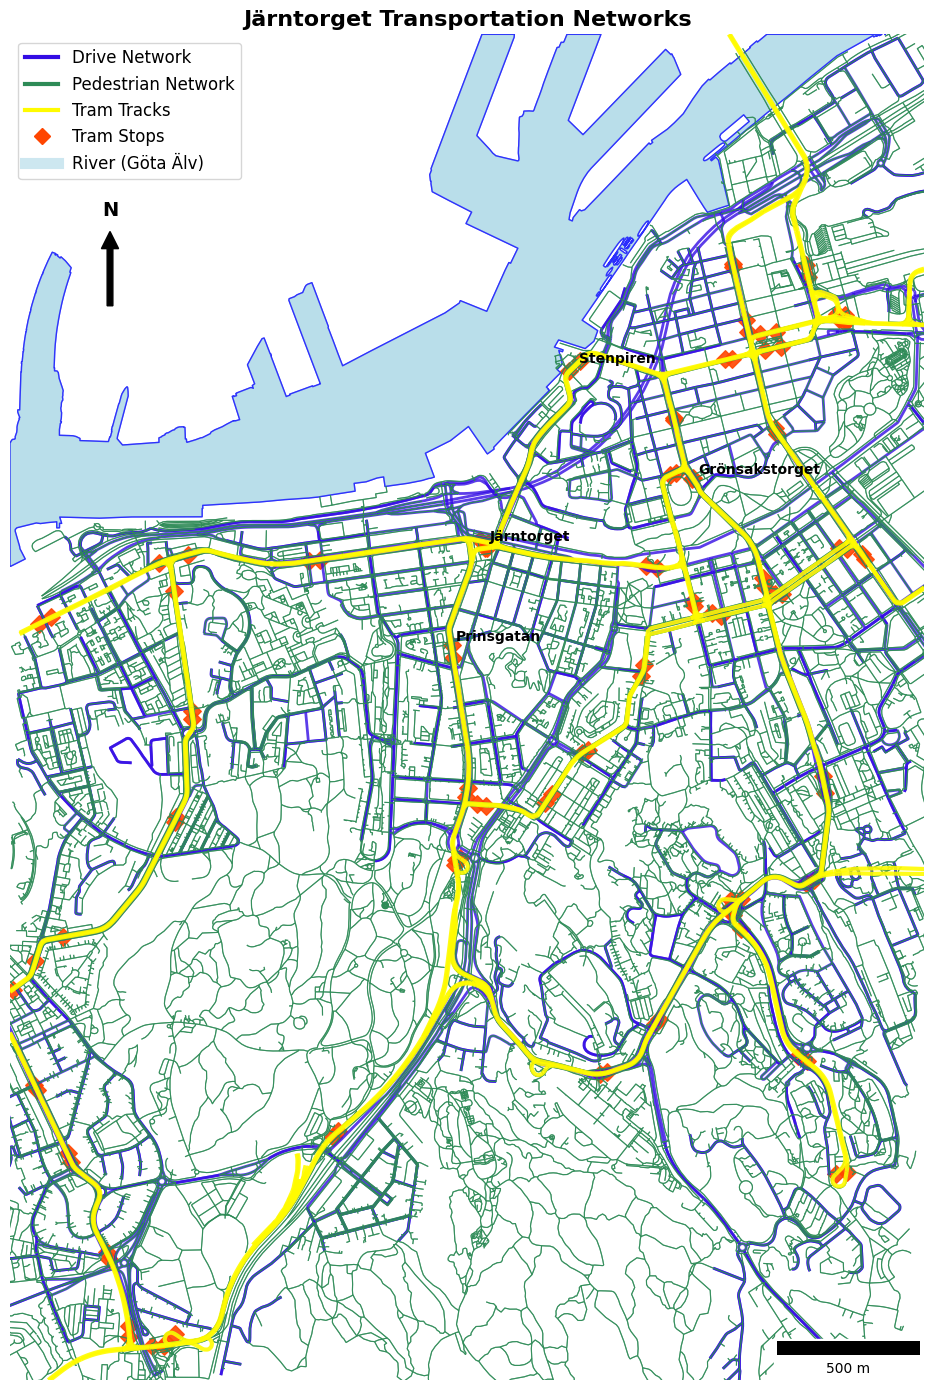

In [11]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow
# ---------------------------------------------
# CONFIG
# ---------------------------------------------
OUT_DIR = "../../processed/networks"
TARGET_CRS = "EPSG:3006"  # projected CRS

# ---------------------------------------------
# Load cleaned layers
# ---------------------------------------------
drive_edges = gpd.read_file(f"{OUT_DIR}/drive_edges_clean.gpkg").to_crs(TARGET_CRS)
walk_edges = gpd.read_file(f"{OUT_DIR}/walk_edges_clean.gpkg").to_crs(TARGET_CRS)

tram_features_path = f"{OUT_DIR}/tram_features_clean.gpkg"
tram_features = gpd.read_file(tram_features_path).to_crs(TARGET_CRS) if os.path.exists(tram_features_path) else None

river_gdf = gpd.read_file(f"{OUT_DIR}/gota_alv.gpkg").to_crs(TARGET_CRS)

# ---------------------------------------------
# POIs
# ---------------------------------------------
pois = [
    (57.699972, 11.952843, "Järntorget"),
    (57.702356, 11.964901, "Grönsakstorget"),
    (57.696783, 11.951081, "Prinsgatan"),
    (57.705685, 11.957579, "Stenpiren")
]

poi_gdf = gpd.GeoDataFrame(
    pois,
    columns=["lat", "lon", "name"],
    geometry=[Point(lon, lat) for lat, lon, _ in pois],
    crs="EPSG:4326"
).to_crs(TARGET_CRS)

# ---------------------------------------------
# Build square bounding box from networks
# ---------------------------------------------
minx = min(drive_edges.total_bounds[0], walk_edges.total_bounds[0])
miny = min(drive_edges.total_bounds[1], walk_edges.total_bounds[1])
maxx = max(drive_edges.total_bounds[2], walk_edges.total_bounds[2])
maxy = max(drive_edges.total_bounds[3], walk_edges.total_bounds[3])

padding = -150  # meters
bbox_poly = box(minx - padding, miny - padding, maxx + padding, maxy + padding)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_poly], crs=TARGET_CRS)

# ---------------------------------------------
# Clip river, tram lines, and POIs
# ---------------------------------------------
river_clipped = gpd.overlay(river_gdf, bbox_gdf, how="intersection")
drive_clipped = drive_edges  # already clipped
walk_clipped = walk_edges    # already clipped

tram_lines = None
tram_points = None
if tram_features is not None:
    tram_lines = tram_features[tram_features.geometry.type.isin(["LineString", "MultiLineString"])]
    tram_points = tram_features[tram_features.geometry.type == "Point"]

    if len(tram_lines) > 0:
        tram_lines = gpd.overlay(tram_lines, bbox_gdf, how="intersection")

    if len(tram_points) > 0:
        tram_points = tram_points[tram_points.intersects(bbox_poly)]

poi_clipped = poi_gdf[poi_gdf.intersects(bbox_poly)]

# ---------------------------------------------
# Plot
# ---------------------------------------------
fig, ax = plt.subplots(figsize=(14, 14))

drive_clipped.plot(ax=ax, color="#330CE4", linewidth=2, alpha=0.8)
walk_clipped.plot(ax=ax, color="#2E8B57", linewidth=0.8, alpha=0.8)

if tram_lines is not None and len(tram_lines) > 0:
    tram_lines.plot(ax=ax, color="#FFFB00", linewidth=3, alpha=0.9)
if tram_points is not None and len(tram_points) > 0:
    tram_points.plot(ax=ax, color="#FF4500", markersize=80, marker="D", alpha=0.9)

if len(river_clipped) > 0:
    river_clipped.plot(ax=ax, color="lightblue", alpha=0.6, edgecolor="blue")

# POIs
for geom, name in zip(poi_clipped.geometry, poi_clipped["name"]):
    ax.annotate(
        name,
        xy=(geom.x, geom.y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        color="black"
    )

# Legend
legend_elements = [
    Line2D([0], [0], color="#330CE4", lw=3, label="Drive Network"),
    Line2D([0], [0], color="#2E8B57", lw=3, label="Pedestrian Network"),
    Line2D([0], [0], color="#FFFB00", lw=3, label="Tram Tracks"),
    Line2D([0], [0], color="#FF4500", marker="D", lw=0, markersize=8, label="Tram Stops"),
    Line2D([0], [0], color="lightblue", lw=8, alpha=0.6, label="River (Göta Älv)"),
]
ax.legend(handles=legend_elements, loc="upper left", fontsize=12)

# Scale bar
scalebar = ScaleBar(1, location="lower right")
ax.add_artist(scalebar)

# North arrow
arrow_length = 200  # meters
arrow_x = minx + 500
arrow_y = maxy - 1100

# Draw the arrow
ax.add_patch(FancyArrow(
    arrow_x, arrow_y, 0, arrow_length,  # dx=0, dy=arrow_length => points up
    width=20,
    head_width=60,
    head_length=60,
    facecolor='black'
))

# Add the 'N' label above the arrow
ax.text(arrow_x, arrow_y + arrow_length + 100, "N",
        ha='center', va='bottom', fontsize=14, fontweight='bold')

# Limit plot to bounding box
ax.set_xlim(minx - padding, maxx + padding)
ax.set_ylim(miny - padding, maxy + padding)

ax.set_title("Järntorget Transportation Networks", fontsize=16, fontweight="bold")
ax.set_axis_off()
plt.tight_layout()
plt.show()
